# Validation of method

### Table of contents

1. [**Schematic of models**](#schem)
2. [**Synthetic**](#syn)
3. [**Biophysical**](#bio)
4. [**Place cells regression**](#place)
5. [**Place cells comodulation**](#corr)

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle

import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])


import os
if not os.path.exists('./output'):
    os.makedirs('./output')


In [ ]:
def render(pgm):
    """
    Wrapper for rendering PGM via daft
    """
    for plate in pgm._plates:
        plate.render(pgm._ctx)

    for edge in pgm._edges:
        edge.render(pgm._ctx)

    for name in pgm._nodes:
        pgm._nodes[name].render(pgm._ctx)



def init_figax(pgm, fig, ax):
    """
    Wrapper for initializing PGM via daft
    """
    pgm._ctx._figure = fig
    ax.axis('off')

    # Set the bounds.
    l0 = pgm._ctx.convert(*pgm._ctx.origin)
    l1 = pgm._ctx.convert(*(pgm._ctx.origin + pgm._ctx.shape))
    ax.set_xlim(l0[0], l1[0])
    ax.set_ylim(l0[1], l1[1])
    ax.set_aspect(1)

    pgm._ctx._ax = ax

### Schematic of model

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask



# animal position
def rbf_kernel(x):
    return np.exp(-.5 * (x**2))


def stationary_GP_trajectories(Tl, dt, trials, tau_list, eps, kernel_func, jitter=1e-9):
    """
    generate smooth GP input
    """
    tau_list_ = tau_list*trials
    out_dims = len(tau_list_)
    
    l = np.array(tau_list_)[:, None]
    v = np.ones(out_dims)

    T = np.arange(Tl)[None, :]*dt / l
    dT = T[:, None, :] - T[..., None] # (tr, T, T)
    K = kernel_func(dT)
    K.reshape(out_dims, -1)[:, ::Tl+1] += jitter
    
    L = np.linalg.cholesky(K)
    v = (L @ eps[..., None])[..., 0]
    a_t = v.reshape(trials, -1, Tl)
    return a_t # trials, tau_arr, time

    

In [ ]:
np.random.seed(7)


# gratings
grid_n = [500, 500]
grid_size = [[-1, 1], [-1, 1]]

k = 10.

gratings = []
for theta in [np.pi/3., np.pi/2., 2*np.pi/3.]:
    ori = np.array([np.cos(theta), np.sin(theta)])[:, None, None]

    func = lambda z: np.sin((ori*z).sum(0)*k)
    _, grating_field = utils.plot.compute_mesh(grid_n, grid_size, func)
    gratings.append(grating_field)
    
gratings = np.array(gratings)


# animal pos
dt = 0.03
Tl = 2500
out_dims = 2
trials = 1
tau_list = [5.0, 5.0]

eps = np.random.randn(out_dims, Tl).astype(np.float64)
an_pos = stationary_GP_trajectories(Tl, dt, trials, tau_list, eps, rbf_kernel)


# probability model and toy data for visualization
K = 11
MC = 1000
beta = 0.1

X = np.arange(100)

mu = X*0.05
std = 0.5 / (X*0.01 + 1)

s = np.log(np.exp( np.random.randn(MC)[:, None, None]*std[None, None, :] + mu[None, None, :] ) + 1)


# MC, K, X
a = np.exp(-s + np.log(s)*np.arange(K)[None, :, None] - \
           sps.gammaln(np.arange(1, K+1)[None, :, None]))
P = a / a.sum(1, keepdims=True)


m = (np.arange(K)[None, :, None]*P).mean(1)
s = ((np.arange(K)**2)[None, :, None]*P).mean(1)
v = s - m**2
ff = v/m

cov = X*0.01


# tuning curves with uncertainties
m_l, m_m, m_u = utils.signal.percentiles_from_samples(torch.tensor(m).float())

ff_l, ff_m, ff_u = utils.signal.percentiles_from_samples(torch.tensor(ff).float())

pP_l, pP_m, pP_u = utils.signal.percentiles_from_samples(torch.tensor(P).float())

In [ ]:
fig = plt.figure(figsize=(8, 3))

fig.text(0.22, 1.05, 'repeatable trials', fontsize=12, ha='center')
fig.text(0.78, 1.05, 'naturalistic behaviour', fontsize=12, ha='center')



### stimulus ###

# histograms
xxs = [20, 90, 30]
l = 1

widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.7, 
                        left=0., right=.45, wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    xx = xxs[k]
    for pp in range(K):
        if k == 2 and pp == K-1:
            lbl = 'UCM'
            lbl2 = 'histogram'
        else:
            lbl, lbl2 = None, None
        
        XX_ = np.linspace(pp-0.5, pp+0.5, 2)
        YY_ = np.ones(2)*np.array(pP_m)[pp, xx]
        YY_l = np.ones(2)*np.array(pP_l)[pp, xx]
        YY_u = np.ones(2)*np.array(pP_u)[pp, xx]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3, label=lbl)
        
        ax.bar(pp, np.maximum(0, YY_+np.random.randn()*0.01), color='tab:grey', 
               label=lbl2, alpha=0.2)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0)
    ax.set_yticks([])

    if k == 0:
        ax.set_xticks([0, K-1])
        ax.set_xticklabels([0, 'K'])
        ax.set_ylabel('prob.', fontsize=10, labelpad=4)
        ax.set_xlabel('# spikes', labelpad=-9, fontsize=10)
    else:
        ax.set_xticks([])
        
    if k == 2:
        ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1.))


# gratings
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0., right=.45, wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    img = gratings[k]
    mask = create_circular_mask(img.shape[-1], img.shape[-2])

    h, w = img.shape[:2]
    mask = create_circular_mask(h, w)
    masked_img = img.copy()
    masked_img[~mask] = 1

    im = utils.plot.visualize_field(
        (fig, ax), masked_img, grid_size, cbar=False, 
        aspect='equal', cmap='gray', vmin=-1, vmax=1)

    circle = plt.Circle((0., 0.), 1.0, color='b', fill=False, clip_on=False)
    ax.add_patch(circle)


    
### behaviour ###
xxs = [40, 99, 50]

widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.7, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])

    xx = xxs[k]
    for pp in range(K):
        XX_ = np.linspace(pp-0.5, pp+0.5, 2)
        YY_ = np.ones(2)*np.array(pP_m)[pp, xx]
        YY_l = np.ones(2)*np.array(pP_l)[pp, xx]
        YY_u = np.ones(2)*np.array(pP_u)[pp, xx]
        line, = ax.plot(XX_, YY_, c='tab:blue', label='', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_xticks([])
    ax.set_ylim(0)
    ax.set_yticks([])


# position
tps = [300, 1000, 1700]
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, hspace=0.0, 
                        height_ratios=heights, top=0.5, bottom=0.0, 
                        left=0.55, right=1., wspace=0.1)

for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    
    ax.annotate("", xy=(0.5, 1.5), xytext=(0.5, 1.1), rotation=np.pi/2., xycoords='axes fraction', 
                arrowprops=dict(arrowstyle="-|>, head_width=.3, head_length=.6", color='k'), 
                annotation_clip=False)
    
    tp = tps[k]

    x = an_pos[0, 0, tp]
    y = an_pos[0, 1, tp]
    dx = (an_pos[0, 0, tp+1]-an_pos[0, 0, tp])*100
    dy = (an_pos[0, 1, tp+1]-an_pos[0, 1, tp])*100

    ax.scatter(x, y, marker='o', facecolor='k', s=40)
    #ax.arrow(x, y, dx, dy)
    ax.plot(an_pos[0, 0, :tp], an_pos[0, 1, :tp], c='k')
    ax.plot(an_pos[0, 0, tp:], an_pos[0, 1, tp:], c='lightgray')
    ylims = ax.get_ylim()
    ax.set_ylim(-2.4, 2.4)
    ax.set_xlim(-2.4, 2.4)
    ax.set_aspect(1.)
    utils.plot.decorate_ax(ax)
            
            
plt.savefig('output/comparison.pdf')
plt.show()

In [7]:
def get_stat_model(mu, lsigma, log_beta, log_gamma, len_x, kernel_class, neurons):
    """
    """
    f_dims = neurons
    x_dims = f_dims
    
    v_t = 1.*np.ones(neurons)
    v_r = -.3*np.ones(neurons)
    tau_m = 0.01*np.ones(neurons)
    tau_s = np.ones(neurons)
    log_beta = log_beta*np.ones(neurons)
    log_gamma = log_gamma*np.ones(neurons)
    
    tau_h = 0.1*np.ones(neurons)
    a = 1.0*np.ones(neurons)
    b = 1000.0*np.ones(neurons)

    IF_model = lib.IF_models.LIF(log_beta, log_gamma, v_t, v_r, tau_s, tau_m)#, tau_h, a, b)
    
    eps_mapping = lib.mappings.Identity(f_dims)

    ### state space GP ###
    var_x = 1.0*np.ones(x_dims)  # GP variance
    len_x = len_x*np.ones((x_dims, 1))  # GP lengthscale

    kernx = kernel_class(x_dims, variance=var_x, lengthscale=len_x)
    #kernx = lib.kernels.IID(jnp.eye(x_dims))
    
    state_space = lib.GP.state_space.FullLDS(kernx, diagonal_site=True)

    ### mu and sigma ###
    params = {'value': mu*jnp.ones((f_dims,))}
    mu_mapping = lib.mappings.Constant(x_dims, f_dims, params)

    params = {'value': lsigma*jnp.ones((f_dims,))}
    lsigma_mapping = lib.mappings.Constant(x_dims, f_dims, params)
    
    ### initial conditions ###
    q_vh_ic = jnp.zeros((num_samps, neurons, IF_model.q_d))
    
    ### IF GP model ###
    model = lib.inference.IF_SSGP(
        state_space, eps_mapping, mu_mapping, lsigma_mapping, IF_model, q_vh_ic, dtype=jnp.float64)
    return model

NameError: name 'GP' is not defined

In [ ]:
x = np.exp(x)
p = x.numpy()[:, 0, :]*np.exp(-np.cumsum(x.numpy()[:, 0, :], axis=1)*dt) # natural time

In [14]:
t = np.arange(1000)
params = {"t0": 100.}

tau, dtau_dt = time_transform(params, t, inverse=False)
t_, dt_dtau = time_transform(params, tau, inverse=True)

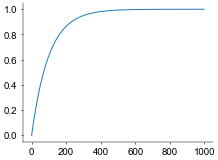

In [15]:
plt.plot(t, tau)

In [ ]:
plt.plot(tau, p.mean(0).T)
plt.plot(tau[:, None].repeat(p.shape[0], axis=1), p.T, alpha=0.3)

In [ ]:
plt.plot(t, p.mean(0).T*dtau_dt)
plt.plot(t[:, None].repeat(p.shape[0], axis=1), p.T*dtau_dt[:, None], alpha=0.3)

In [ ]:
(p*dt).sum(1)

In [ ]:
fig = plt.figure(figsize=(8,5)) # plot fits
fig.text(-0.21, 1.16, 'A', transform=ax.transAxes, size=15)

time_bins = I_ext[0].shape[0]
tt = np.arange(time_bins)*dt



widths = [1]
heights = [1, 1, 1, 2]
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, 
                        left=0., right=0.7, bottom=0., top=1.0)

ax = fig.add_subplot(spec[0, 0])